# Vision Transformer

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn

import torchvision



from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Pretrained model

### import model

* 搜尋 pytorch vision_transformer pretrained, 就可以找到 torchvision 有 pretrained model  
* https://pytorch.org/vision/main/models/vision_transformer.html

In [69]:
# requires torchvision >= 0.13, "DEFAULT" means best available
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

In [70]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

### 改最後一層就好

In [71]:
# 3. Freeze the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

### Get data

In [60]:
# from helper_functions import download_data

# # Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                            destination="pizza_steak_sushi")
# image_path

In [61]:
# Setup train and test directory paths
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test" 
train_dir, test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

### Data loader

In [62]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [63]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                            test_dir=test_dir,
                                            transform=pretrained_vit_transforms,
                                            batch_size=32) 
# Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


* 看一下 image

In [64]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader_pretrained))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape)
print(image.max())
print(image.min())
print(label)

torch.Size([3, 224, 224])
tensor(2.0948)
tensor(-1.9832)
tensor(2)


* 可以看到，transform 將影像轉成 tensor (0 到 1 float) 後，又減去 custom mean 和 除上 custom sd, 使得現在影像是介於 -2~2 之間. 
* 這對於訓練來說是 ok 的 (因為當初 pretrained 就是餵這個 range 進去;  而且對 NN 來說，只要數字就好，他才不 care 一定要 0~1 float). 
* 但對於 show 圖就很麻煩，所以寫個 function 來 show 圖

In [65]:
def show_torch_img(torch_obj, label):
    
    custom_mean = torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
    custom_sd = torch.tensor([[[0.229]], [[0.224]], [[0.225]]])
    image = torch_obj*custom_sd + custom_mean
    
    # Plot image with matplotlib
    plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
    plt.title(class_names[label])
    plt.axis(False);

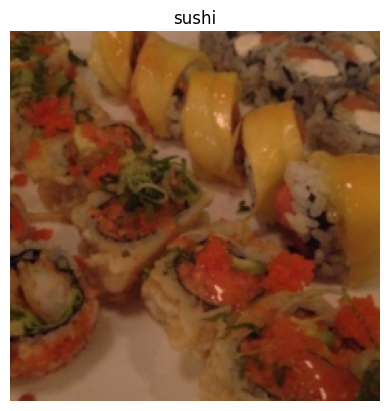

In [66]:
show_torch_img(image, label)

In [67]:
image.shape

torch.Size([3, 224, 224])

### training

In [72]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|███                           | 1/10 [00:08<01:18,  8.69s/it]

Epoch: 1 | train_loss: 0.8129 | train_acc: 0.6602 | test_loss: 0.4731 | test_acc: 0.8333


 20%|██████                        | 2/10 [00:17<01:09,  8.70s/it]

Epoch: 2 | train_loss: 0.1821 | train_acc: 0.9414 | test_loss: 0.4134 | test_acc: 0.8229


 30%|█████████                     | 3/10 [00:26<01:01,  8.73s/it]

Epoch: 3 | train_loss: 0.0303 | train_acc: 1.0000 | test_loss: 0.1580 | test_acc: 0.9375


 40%|████████████                  | 4/10 [00:34<00:52,  8.75s/it]

Epoch: 4 | train_loss: 0.0183 | train_acc: 0.9922 | test_loss: 0.1285 | test_acc: 0.9688


 50%|███████████████               | 5/10 [00:43<00:44,  8.81s/it]

Epoch: 5 | train_loss: 0.0050 | train_acc: 1.0000 | test_loss: 0.1730 | test_acc: 0.9479


 60%|██████████████████            | 6/10 [00:52<00:35,  8.82s/it]

Epoch: 6 | train_loss: 0.0016 | train_acc: 1.0000 | test_loss: 0.1540 | test_acc: 0.9375


 70%|█████████████████████         | 7/10 [01:01<00:26,  8.85s/it]

Epoch: 7 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 0.1450 | test_acc: 0.9583


 80%|████████████████████████      | 8/10 [01:10<00:17,  8.88s/it]

Epoch: 8 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.1432 | test_acc: 0.9583


 90%|███████████████████████████   | 9/10 [01:19<00:08,  8.92s/it]

Epoch: 9 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.1435 | test_acc: 0.9792


100%|█████████████████████████████| 10/10 [01:28<00:00,  8.86s/it]

Epoch: 10 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.1442 | test_acc: 0.9792


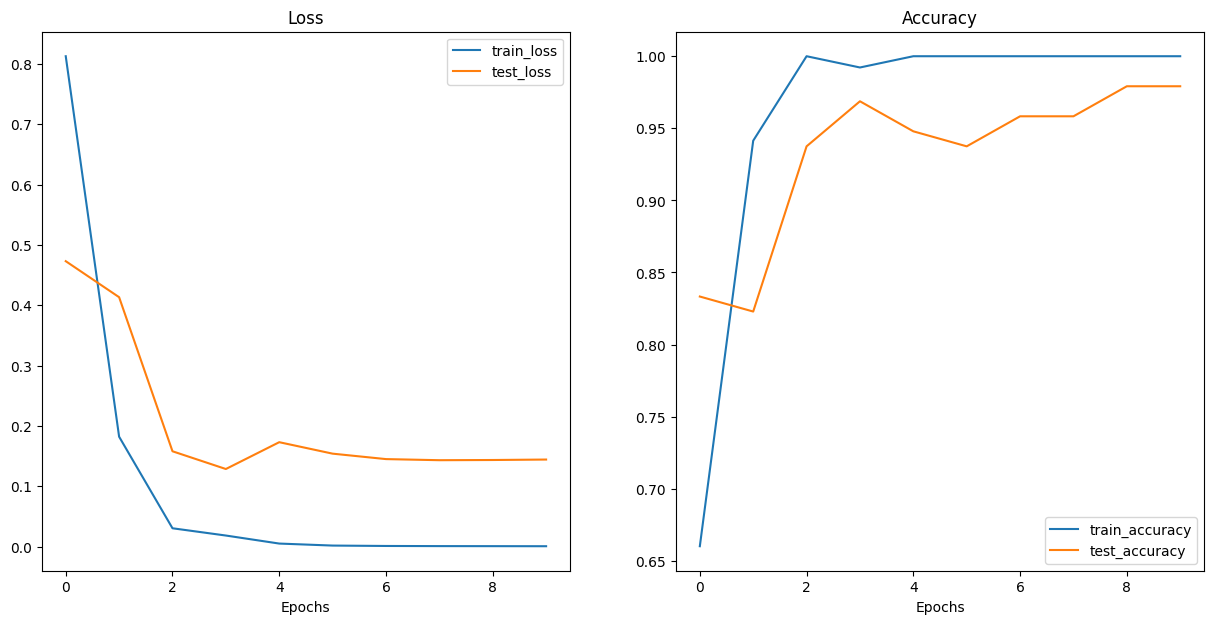

In [73]:
# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results) 

* 做個預測：

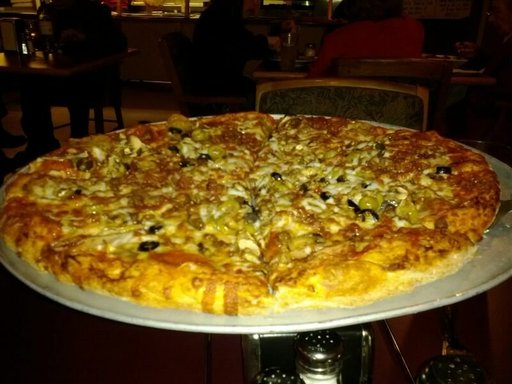

In [74]:
img_try = Image.open("data/pizza_steak_sushi/test/pizza/1152100.jpg")
img_try

In [75]:
img_torch = pretrained_vit_transforms(img_try)

In [76]:
pred_prob = pretrained_vit(img_torch.unsqueeze(0).to(device))
pred_prob

tensor([[ 6.4871, -4.3674, -1.6217]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [77]:
class_idx = torch.argmax(pred_prob)
class_names[class_idx]

'pizza'

### save

In [78]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="output_save_models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: output_save_models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


* 看一下檔案有多大

In [79]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("output_save_models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
